In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks
# Disclaimer: Most of this is unoriginal and ripped directly from a random online tutorial.
#https://rain.thecomicseries.com/comics/398#content-start

In [3]:
data_planet = pd.read_excel("ep206103150.xlsx")

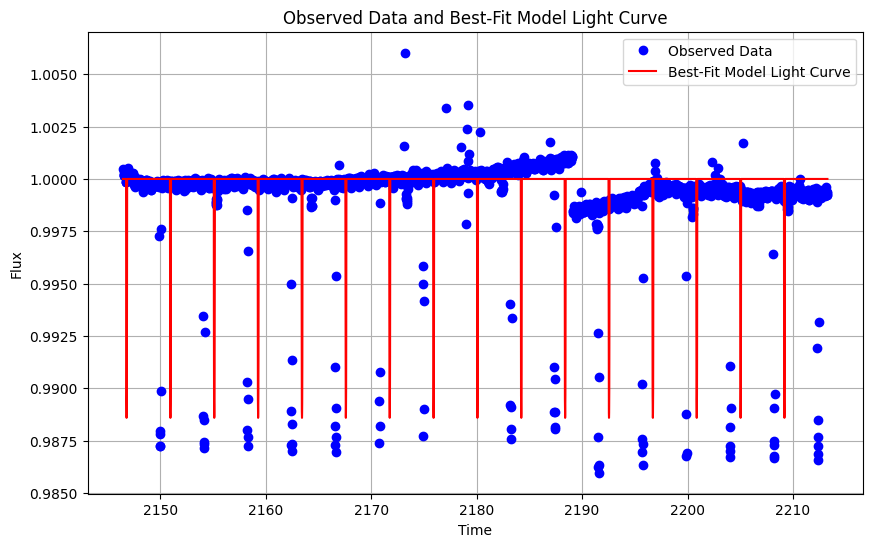

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import batman

# Load data (provide the path to your dataset)
data_planet = pd.read_excel("ep206103150.xlsx")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

# Define a function to generate the model light curve with best-fit parameters
def generate_model(time, params):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

# Best-fit parameters for WASP-47b from the papers
best_fit_params = batman.TransitParams()
best_fit_params.t0 = 2150.96
best_fit_params.per = 4.1591
best_fit_params.rp = 0.10186
best_fit_params.a = 13.18
best_fit_params.inc = 87.47
best_fit_params.ecc = 0.0
best_fit_params.w = 90.0
best_fit_params.limb_dark = "quadratic"  # Set the limb darkening model
best_fit_params.u = [0.4, 0.2]  # Limb darkening parameters

# Generate the model light curve with best-fit parameters
model_time = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)
model_flux = generate_model(model_time, best_fit_params)

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(time_data, flux_data, marker='o', linestyle='', color='b', label='Observed Data')

# Plot the model with a higher density of points
plt.plot(model_time, model_flux, color='r', label='Best-Fit Model Light Curve')

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Observed Data and Best-Fit Model Light Curve')
plt.legend()
plt.grid(True)
plt.show()


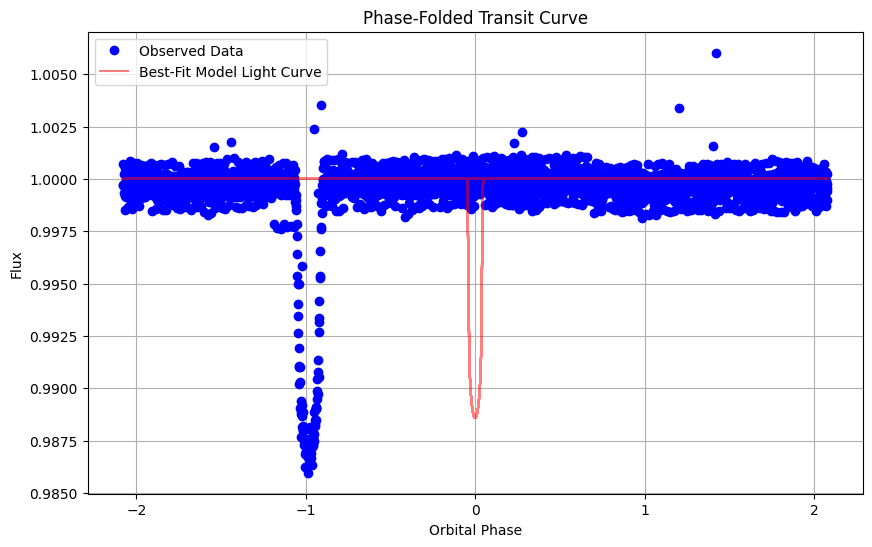

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks

# Load data (provide the path to your dataset)
data_planet = pd.read_excel("ep206103150.xlsx")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None

# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        initial_params['t0'] = time[first_dip_index]

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = initial_params['t0']
    params.per = initial_params['per']
    params.rp = initial_params['rp']
    params.a = (params.per**2)**(1/3)
    params.inc = initial_params['inc']
    params.ecc = initial_params['ecc']
    params.w = initial_params['w']
    params.limb_dark = "quadratic"  # Change the limb darkening model
    params.u = [initial_params['u1'], initial_params['u2']]  # Quadratic limb darkening has 2 parameters

    # Initialize the BATMAN transit model
    m = batman.TransitModel(params, time_fine)

    # Define a function to minimize, which calculates the residuals
    def objective(p):
        # Update parameters
        params.t0, params.rp, params.per, params.a, params.u[0], params.u[1] = p

        # Initialize the BATMAN transit model with updated parameters
        m = batman.TransitModel(params, time)

        # Calculate the model light curve
        flux_model = m.light_curve(params)

        # Calculate residuals
        residuals = flux - flux_model

        # Return the sum of squared residuals
        return np.sum(residuals**2)

    # Perform the optimization to find best-fit parameters (t0, rp, per, a, u1, u2)
    initial_guess = [params.t0, params.rp, params.per, params.a, params.u[0], params.u[1]]
    bounds = [(params.t0 - 5, params.t0 + 5),  # Adjusting bounds for better exploration
              (params.rp * 0.5, params.rp * 2.0),
              (params.per * 0.8, params.per * 1.2),
              (params.a * 0.8, params.a * 1.2),
              (0.0, 1.0),
              (0.0, 1.0)]

    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

    # Get the best-fit parameters
    best_fit_params = result.x
    params.t0, params.rp, params.per, params.a, params.u[0], params.u[1] = best_fit_params

    print("Final parameters:")
    print("t0:", params.t0)
    print("rp:", params.rp)
    print("per:", params.per)
    print("a:", params.a)
    print("u1:", params.u[0])
    print("u2:", params.u[1])

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time)

    # Calculate the model light curve
    flux_model = m.light_curve(params)

    return flux_model, best_fit_params

# Function to generate the model light curve with given parameters
def generate_model(time, params):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

# Generate the model light curve with best-fit parameters
model_time = np.linspace(time_data.min(), time_data.max(), len(time_data) * 10)
model_flux = generate_model(model_time, best_fit_params)

# Phase-fold the model
model_phase = ((model_time - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Phase-fold the data
orbital_phase = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(orbital_phase, flux_data, marker='o', linestyle='', color='b', label='Observed Data')

# Plot the model with a continuous line (higher density of points)
plt.plot(model_phase, model_flux, color='r', label='Best-Fit Model Light Curve', alpha=0.5)

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')
plt.title("Phase-Folded Transit Curve")
plt.legend() 
plt.grid(True)
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks

# Load data (provide the path to your dataset)
data_planet = pd.read_excel("ep206103150.xlsx")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None
    
# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        initial_params['t0'] = time[first_dip_index]

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = initial_params['t0']
    params.per = initial_params['per']
    params.rp = initial_params['rp']
    params.a = (params.per**2)**(1/3)
    params.inc = initial_params['inc']
    params.ecc = initial_params['ecc']
    params.w = initial_params['w']
    params.limb_dark = "quadratic"  # Change the limb darkening model
    params.u = [initial_params['u1'], initial_params['u2']]  # Quadratic limb darkening has 2 parameters

    # Initialize the BATMAN transit model
    m = batman.TransitModel(params, time_fine)

    # Define a function to minimize, which calculates the residuals
    def objective(p):
        # Update parameters
        params.t0, params.rp, params.per, params.a, params.u[0], params.u[1] = p

        # Initialize the BATMAN transit model with updated parameters
        m = batman.TransitModel(params, time)

        # Calculate the model light curve
        flux_model = m.light_curve(params)

        # Calculate residuals
        residuals = flux - flux_model

        # Return the sum of squared residuals
        return np.sum(residuals**2)

    # Perform the optimization to find best-fit parameters (t0, rp, per, a, u1, u2)
    initial_guess = [params.t0, params.rp, params.per, params.a, params.u[0], params.u[1]]
    bounds = [(params.t0 - 5, params.t0 + 5),  # Adjusting bounds for better exploration
              (params.rp * 0.5, params.rp * 2.0),
              (params.per * 0.8, params.per * 1.2),
              (params.a * 0.8, params.a * 1.2),
              (0.0, 1.0),
              (0.0, 1.0)]

    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

    # Get the best-fit parameters
    best_fit_params = result.x
    params.t0, params.rp, params.per, params.a, params.u[0], params.u[1] = best_fit_params

    print("Final parameters:")
    print("t0:", params.t0)
    print("rp:", params.rp)
    print("per:", params.per)
    print("a:", params.a)
    print("u1:", params.u[0])
    print("u2:", params.u[1])

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time)

    # Calculate the model light curve
    flux_model = m.light_curve(params)

    return flux_model, best_fit_params

# Function to generate the model light curve with given parameters
def generate_model(time, params):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

# Call the function to obtain best-fit parameters
best_fit_flux, best_fit_params = fit_transit_parameters(time_data, flux_data, initial_params)

# Generate the model light curve with best-fit parameters
model_flux = generate_model(time_data, best_fit_params)

# Phase-fold the data
orbital_phase = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Phase-fold the model using the same approach as for the data
model_phase = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(orbital_phase, flux_data, marker='o', linestyle='', color='b', label='Observed Data')

# Plot the model with a continuous line (higher density of points)
plt.plot(model_phase, model_flux, color='r', label='Best-Fit Model Light Curve', alpha=0.5)

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')
plt.title('Refined Phase-Folded Observed Data and Best-Fit Model Light Curve')
plt.legend()
plt.grid(True)
plt.show()


Final parameters:
t0: 2154.11624111765
rp: 0.05
per: 1.0611813588687005
a: 1.1999441876959582
u1: 2.602041271204878e-06
u2: 0.0001249732992919395


AttributeError: 'numpy.ndarray' object has no attribute 'limb_dark'